In [1]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt
import cv2

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

### Prepare Images and Labels

In [3]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

def load_images(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [4]:
train_images = tf.data.Dataset.list_files('/kaggle/input/face-det-data/aug_data/train/images/*.jpg', shuffle=False)
train_images = train_images.map(load_images)
train_images = train_images.map(lambda x: tf.image.resize(x, (120, 120)))
train_images = train_images.map(lambda x: x / 255)

test_images = tf.data.Dataset.list_files('/kaggle/input/face-det-data/aug_data/test/images/*.jpg', shuffle=False)
test_images = test_images.map(load_images)
test_images = test_images.map(lambda x: tf.image.resize(x, (120, 120)))
test_images = test_images.map(lambda x: x / 255)

val_images = tf.data.Dataset.list_files('/kaggle/input/face-det-data/aug_data/val/images/*.jpg', shuffle=False)
val_images = val_images.map(load_images)
val_images = val_images.map(lambda x: tf.image.resize(x, (120, 120)))
val_images = val_images.map(lambda x: x / 255)

In [5]:
train_labels = tf.data.Dataset.list_files('/kaggle/input/face-det-data/aug_data/train/labels/*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

test_labels = tf.data.Dataset.list_files('/kaggle/input/face-det-data/aug_data/test/labels/*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

val_labels = tf.data.Dataset.list_files('/kaggle/input/face-det-data/aug_data/val/labels/*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [6]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(10000, 10000, 1900, 1900, 2300, 2300)

In [7]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

### View Images and Annotations

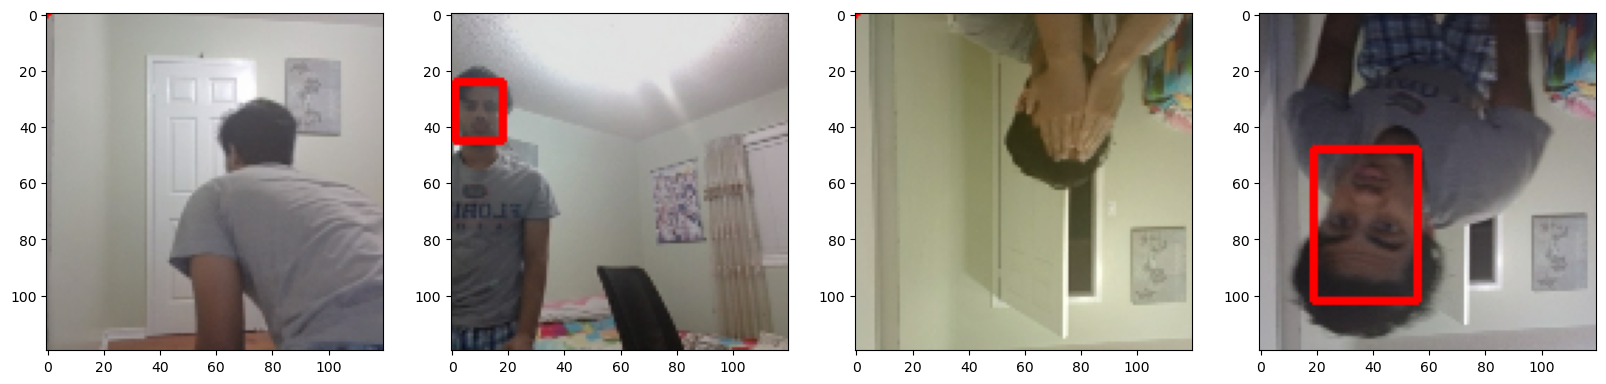

In [8]:
data_samples = train.as_numpy_iterator()
res = data_samples.next()
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)

### Build the Neural Network

In [9]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

In [10]:
vgg = VGG16(include_top=False)
vgg.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                              

In [11]:
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

In [12]:
facetracker = build_model()

In [13]:
facetracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_2[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d (GlobalMa  (None, 512)         0           ['vgg16[0][0]']                  
 xPooling2D)                                                                                  

In [14]:
X, y = train.as_numpy_iterator().next()

In [15]:
X.shape

(8, 120, 120, 3)

In [16]:
classes, coords = facetracker.predict(X)

1/1 [==============================] - 6s 6s/step


### Training

In [18]:
batches_per_epoch = len(train)
initial_learning_rate = 0.0001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=batches_per_epoch, decay_rate=0.75)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

In [19]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [20]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

In [21]:
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=4.650257>

In [22]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.55739224>

In [23]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=4.650257>

In [24]:
class FaceTracker(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, optimizer, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.optimizer = optimizer
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        optimizer.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [25]:
model = FaceTracker(facetracker)

In [26]:
model.compile(optimizer, classloss, regressloss)

In [27]:
logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [30]:
hist = model.fit(train, epochs=40, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/40
1250/1250 [==============================] - 95s 59ms/step - total_loss: 0.2247 - class_loss: 0.0676 - regress_loss: 0.1909 - val_total_loss: 0.0583 - val_class_loss: 0.0320 - val_regress_loss: 0.0423
Epoch 2/40
1250/1250 [==============================] - 73s 49ms/step - total_loss: 0.0326 - class_loss: 0.0095 - regress_loss: 0.0279 - val_total_loss: 0.0170 - val_class_loss: 0.0027 - val_regress_loss: 0.0157
Epoch 3/40
1250/1250 [==============================] - 73s 49ms/step - total_loss: 0.0309 - class_loss: 0.0084 - regress_loss: 0.0267 - val_total_loss: 0.0062 - val_class_loss: 2.0823e-04 - val_regress_loss: 0.0061
Epoch 4/40
1250/1250 [==============================] - 73s 49ms/step - total_loss: 0.0116 - class_loss: 0.0030 - regress_loss: 0.0101 - val_total_loss: 0.0088 - val_class_loss: 2.4439e-05 - val_regress_loss: 0.0088
Epoch 5/40
1250/1250 [==============================] - 75s 49ms/step - total_loss: 0.0096 - class_loss: 0.0025 - regress_loss: 0.0084 - val_tot

In [31]:
hist.history

{'total_loss': [0.04228660836815834,
  0.022212298586964607,
  0.0045508951880037785,
  0.009440453723073006,
  0.002348798792809248,
  0.004595117177814245,
  0.0008460776298306882,
  0.0013333249371498823,
  0.0012371322372928262,
  0.0009033114765770733,
  0.0006724869017489254,
  0.00043041439494118094,
  0.00046224193647503853,
  0.0016104475362226367,
  0.0003096704604104161,
  0.00015304012049455196,
  0.0001734804973239079,
  0.000139472889713943,
  0.00016025383956730366,
  0.0003317391383461654,
  0.00015254912432283163,
  0.00010039842163678259,
  0.00014279689639806747,
  0.00022735854145139456,
  0.0001536717900307849,
  0.00021093069517519325,
  0.0003094048297498375,
  7.350811938522384e-05,
  0.00019753503147512674,
  0.0001255904498975724,
  0.00013507982657756656,
  0.00017595497774891555,
  0.000202091847313568,
  0.0001827971573220566,
  9.011563088279217e-05,
  0.0003037936694454402,
  0.0006344850407913327,
  0.00010366887727286667,
  0.00022546443506143987,
  0.0

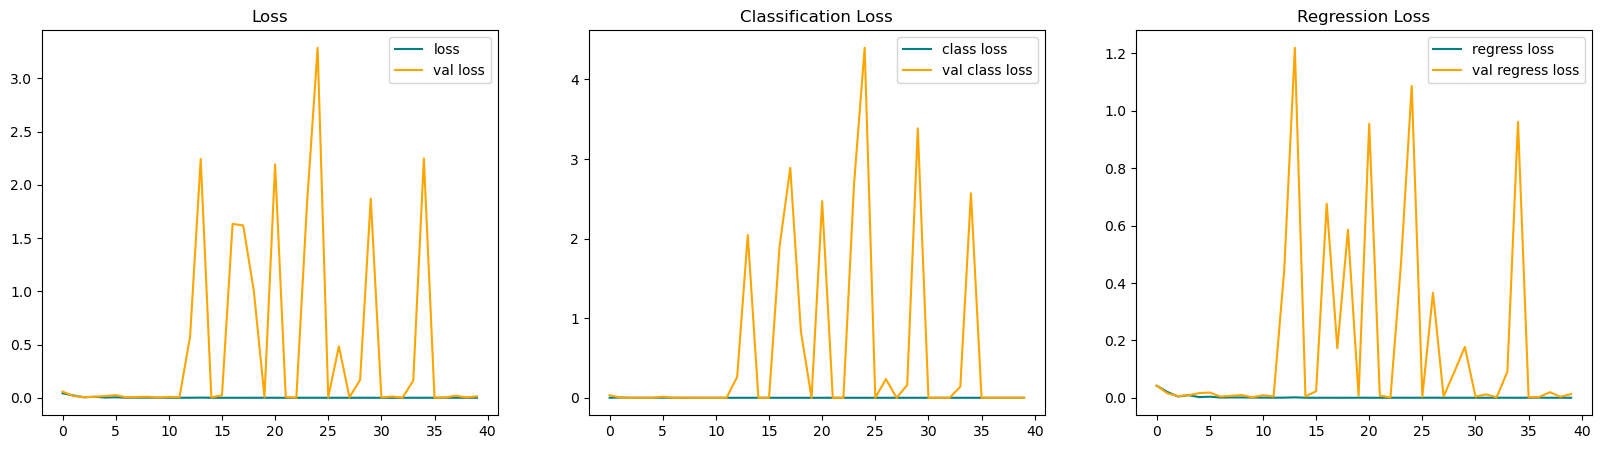

In [32]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

### Evaluate

In [33]:
test_data = test.as_numpy_iterator()
test_sample = test_data.next()

In [34]:
yhat = facetracker.predict(test_sample[0])

1/1 [==============================] - 0s 115ms/step


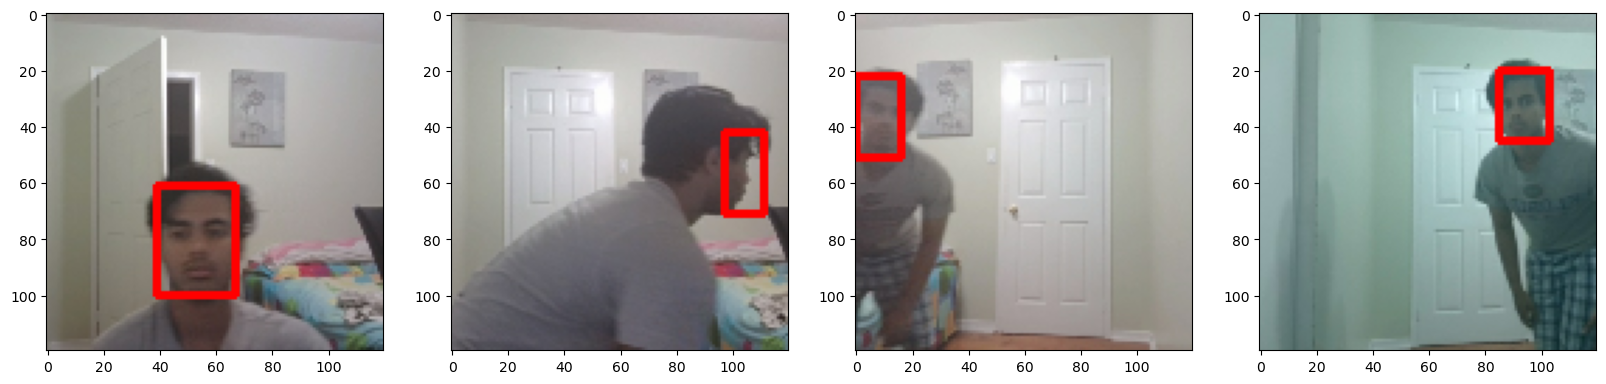

In [36]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

In [37]:
from tensorflow.keras.models import load_model

In [38]:
facetracker.save('facetracker3.h5')
facetracker = load_model('facetracker3.h5')